# 01 - Create descriptive statistics for NYC Yellow Cab data set

In this notebook you will

- Launch a [Coiled Cluster]()
- Load a [Dask dataframe]() into your workspace
- Perform math operations on the Dask dataframe to describe statistics of tips, total distance traveled, and fare amounts

You will need

- Coiled 
- Dask
- 

## Launch a cluster

The first step is to spin up a Dask Cluster. In Coiled, this is done by creating a `coiled.Cluster` instance, there are [several keyword arguments](https://docs.coiled.io/user_guide/api.html#coiled.Cluster) you can use to specify the details of your cluster further. Please read the [cluster creation documentation](https://docs.coiled.io/user_guide/cluster_creation.html) to know more.

Note that we will give a name to this cluster, if you don't specify this keyword argument, clusters will be given a unique randomly generated name.

In [57]:
import coiled

cluster = coiled.Cluster(name="taxi-analysis", n_workers=10)

Output()

Found software environment build


/home/ryan/.conda/envs/coiledcloud/lib/python3.9/site-packages/coiled/cluster.py:629: UserWarning: Unable to locate credentials
  warnings.warn(str(e))


Once a cluster has been created (you can see the status on your [Coiled dashboard](https://cloud.coiled.io/)), you can connect Dask to the cluster by creating a `distributed.Client` instance.

In [2]:
from dask.distributed import Client

client = Client(cluster)
client

/home/ryan/.conda/envs/coiledcloud/lib/python3.9/site-packages/distributed/client.py:1148: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| blosc   | None          | 1.10.2        | 1.10.2        |
| lz4     | None          | 3.1.3         | 3.1.3         |
| python  | 3.9.0.final.0 | 3.9.4.final.0 | 3.9.4.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tls://ec2-3-238-111-118.compute-1.amazonaws.com:8786 Dashboard: http://ec2-3-238-111-118.compute-1.amazonaws.com:8787,Cluster Workers: 8 Cores: 16 Memory: 64.00 GiB


## Analyze data in the cloud

Now that we have our cluster running and Dask connected to it, let's run a computation. This example will run the computation on about 84 million rows.

In [3]:
import dask.dataframe as dd

taxi_full = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    dtype={
        "payment_type": "UInt8",
        "VendorID": "UInt8",
        "passenger_count": "UInt8",
        "RatecodeID": "UInt8",
    },
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

In [7]:
# print(taxi_full.tip_amount.mean().compute())
# print(taxi_full.trip_distance.mean().compute())
# print(taxi_full.fare_amount.mean().compute())
# print(len(taxi_full))

taxi_full[['tip_amount', 'trip_distance', 'fare_amount']].describe().compute()

,tip_amount,trip_distance,fare_amount
count,8.439902e+07,8.439902e+07,8.439902e+07
mean,2.195064e+00,3.000928e+00,1.334399e+01
std,1.565706e+01,8.091114e+00,1.743749e+02
min,-2.210000e+02,-3.726453e+04,-1.856000e+03
25%,5.000000e-01,1.270000e+00,8.000000e+00
50%,2.060000e+00,2.320000e+00,1.250000e+01
75%,3.360000e+00,1.177000e+01,4.201000e+01
max,1.414920e+05,4.597722e+04,9.432748e+05


In [9]:
taxi_full_wtips = taxi_full[(taxi_full['tip_amount'] > 0) & (taxi_full['fare_amount'] > 0) & (taxi_full['trip_distance'] > 0)]

In [11]:
len(taxi_full_wtips)/len(taxi_full)

0.6871754516483183

In [48]:
# print(taxi_full_wtips.tip_amount.mean().compute(), taxi_full_wtips.tip_amount.std().compute())
# print(taxi_full_wtips.trip_distance.mean().compute())
# print(taxi_full_wtips.fare_amount.mean().compute())
# print(len(taxi_full_wtips))

taxi_full_wtips[['tip_amount', 'trip_distance', 'fare_amount']].describe().compute()

,tip_amount,trip_distance,fare_amount
count,5.799693e+07,5.799693e+07,5.799693e+07
mean,3.153767e+00,3.010900e+00,1.316246e+01
std,2.776373e+00,3.846897e+00,1.144604e+01
min,1.000000e-02,1.000000e-02,1.000000e-02
25%,1.960000e+00,1.330000e+00,7.500000e+00
50%,2.660000e+00,2.300000e+00,1.100000e+01
75%,1.330000e+01,1.555000e+01,6.500000e+01
max,1.624640e+03,8.318000e+02,9.022000e+03


In [46]:
import dask.array as da
h_fare, bins_fare = da.histogram(taxi_full_wtips['fare_amount'], bins = np.logspace(0,2,50), range = [0, 150])
h_trip, bins_trip = da.histogram(taxi_full_wtips['trip_distance'], bins = np.logspace(-1,2,50), range = [0, 150])
h_tip, bins_tip = da.histogram(taxi_full_wtips['tip_amount'], bins = np.logspace(-1,2,50), range = [0, 100])

In [50]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

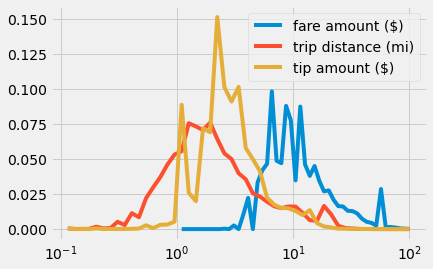

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [56]:
plt.semilogx(bins_fare[1:], h_fare/np.sum(h_fare), label = 'fare amount ($)')
# plt.semilogx([13.162, 13.162], [0, 0.15])
plt.semilogx(bins_trip[1:], h_trip/np.sum(h_trip), label = 'trip distance (mi)')
plt.semilogx(bins_tip[1:], h_tip/np.sum(h_tip), label = 'tip amount ($)')
plt.legend();

## Wrapping up

In this notebook, you 
- loaded the NYC Yellow Cab data set into Dask dataframe on a Coiled cluster
- calculated summative statistics for the taxi fares, trip distances, and tips
- plotted the histogram for taxi fares, trip distances, and tips

> __Note__: These statistical measures and the following predictive analysis using ordinary least squares regression assume that fares and distances are random variables, but in general fares should be proportional to distance traveled. You should keep this in mind while considering the results of this analysis. 

In [30]:
coiled.delete_cluster(name="taxi-analysis")
client.close()

Cluster deleted successfully.